In [1]:
import os

import pandas as pd
import tiktoken

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,build_text_unit_context,LocalContextBuilder
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore



import os

import pandas as pd
import tiktoken

from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch



In [2]:
#INPUT_DIR = "./inputs/operation dulce"
INPUT_DIR = "/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/output"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

In [3]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head()

Entity count: 2229


,level,title,type,description,source_id,degree,human_readable_id,id,graph_embedding,community,size,entity_type,top_level_node_id,x,y
0,0,MIKE JUDD,PERSON,"Mike Judd is an author of the book ""Soldering ...",e82f9f1a4a5f409251687ca54991574a,2,0,fb1ad80c6e4842c2ac554e156ce593f5,None,None,NaN,None,fb1ad80c6e4842c2ac554e156ce593f5,NaN,NaN
1,0,KEITH BRINDLEY,PERSON,"Keith Brindley is an author of the book ""Solde...",e82f9f1a4a5f409251687ca54991574a,2,1,fbb428960ebc4729b5e2e1c4d0eaabfe,None,None,NaN,None,fbb428960ebc4729b5e2e1c4d0eaabfe,NaN,NaN
2,0,NEWNES,ORGANIZATION,"Newnes is the publisher of the book ""Soldering...",e82f9f1a4a5f409251687ca54991574a,9,2,7c9524a8d3a545768248a79e49a4d846,None,None,NaN,None,7c9524a8d3a545768248a79e49a4d846,NaN,NaN
3,0,BUTTERWORTH-HEINEMANN,ORGANIZATION,Butterworth-Heinemann is the parent company of...,e82f9f1a4a5f409251687ca54991574a,2,3,24c36d4df1d645dab616505a361365fd,None,None,NaN,None,24c36d4df1d645dab616505a361365fd,NaN,NaN
4,0,REED EDUCATIONAL AND PROFESSIONAL PUBLISHING LTD,ORGANIZATION,Reed Educational and Professional Publishing L...,e82f9f1a4a5f409251687ca54991574a,2,4,38041978d9114fc9842436b762783fae,None,None,NaN,None,38041978d9114fc9842436b762783fae,NaN,NaN


In [4]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head()

Relationship count: 3179


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,MIKE JUDD,NEWNES,5.0,Mike Judd is an author of a book published by ...,[e82f9f1a4a5f409251687ca54991574a],2253aca4b1544f899ab80a6bcac6a6c4,0,2,9,11
1,MIKE JUDD,SOLDERING IN ELECTRONICS ASSEMBLY,5.0,"Mike Judd is an author of the book ""Soldering ...",[e82f9f1a4a5f409251687ca54991574a],dd2c46e8c5aa42888c4011c9490cc0ab,1,2,4,6
2,KEITH BRINDLEY,NEWNES,5.0,Keith Brindley is an author of a book publishe...,[e82f9f1a4a5f409251687ca54991574a],d9b99f755a494293ac9627a0a01b0b52,2,2,9,11
3,KEITH BRINDLEY,SOLDERING IN ELECTRONICS ASSEMBLY,5.0,"Keith Brindley is an author of the book ""Solde...",[e82f9f1a4a5f409251687ca54991574a],7ecd045f2385449fba6f653a0c0920a3,3,2,4,6
4,NEWNES,BUTTERWORTH-HEINEMANN,8.0,Newnes is an imprint of Butterworth-Heinemann,[e82f9f1a4a5f409251687ca54991574a],983ea8ae7ad643f98eea079002fadcf2,4,9,2,11


In [5]:
# NOTE: covariates are turned off by default, because they generally need prompt tuning to be valuable
# Please see the GRAPHRAG_CLAIM_* settings
"""covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

claims = read_indexer_covariates(covariate_df)

print(f"Claim records: {len(claims)}")
covariates = {"claims": claims}"""

'covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")\n\nclaims = read_indexer_covariates(covariate_df)\n\nprint(f"Claim records: {len(claims)}")\ncovariates = {"claims": claims}'

In [ ]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 73


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,58,# Soldering and Electronics Assembly\n\nThis c...,2,7.0,Soldering and Electronics Assembly,The impact severity rating is high due to the ...,This community revolves around the process of ...,[{'explanation': 'Soldering is the central ent...,"{\n ""title"": ""Soldering and Electronics Ass...",b35de978-ca01-44d7-a012-7b6526ae3412
1,59,# Flux and Solderability\n\nThis community rev...,2,3.0,Flux and Solderability,The impact severity rating is low due to the l...,This community revolves around the concept of ...,[{'explanation': 'Flux is a key entity in this...,"{\n ""title"": ""Flux and Solderability"",\n ...",287df284-3c47-4e78-8024-7bfed14af4ee
2,60,# Assembly and its Associated Faults\n\nThis c...,2,7.0,Assembly and its Associated Faults,The impact severity rating is high due to the ...,This community revolves around the concept of ...,[{'explanation': 'Assembly is a fundamental pr...,"{\n ""title"": ""Assembly and its Associated F...",797c3220-46e5-4c6f-9a3a-83da48391eb3
3,61,# Component Assembly and Manufacturing\n\nThis...,2,7.0,Component Assembly and Manufacturing,The impact severity rating is high due to the ...,This community focuses on the assembly and man...,[{'explanation': 'Components are the fundament...,"{\n ""title"": ""Component Assembly and Manufa...",65dff29b-096d-4a55-aaef-66de20e2de64
4,62,# Electrical Connections and Circuits\n\nThis ...,2,3.0,Electrical Connections and Circuits,The impact severity rating is low due to the t...,This community revolves around the concept of ...,[{'explanation': 'Soldering is a crucial techn...,"{\n ""title"": ""Electrical Connections and Ci...",d294c6d5-ba91-42de-a01e-1aa6c4b21978


In [7]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()


Text unit records: 28


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,e82f9f1a4a5f409251687ca54991574a,"6G a®*: s +. i 2 a <, s e Ged SECOND EDITION\n...",791,[soldering.pdf_0],"[fb1ad80c6e4842c2ac554e156ce593f5, fbb428960eb...","[2253aca4b1544f899ab80a6bcac6a6c4, dd2c46e8c5a..."
1,e79b884d7685eec5915f598876065fa0,Foreword\n\nPreface\n\nAcknowledgements\n\n1 S...,830,[soldering.pdf_1],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[18a22fbd59984239829041aaa1f09ce5, 79bcefb0932..."
2,8283f5a9bf11a066788202bdc6651675,TIME ON ITS SIDE 3\n\nmake up the circuit of a...,796,[soldering.pdf_10],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[99835832c2f3439880b49c6c38bf68d3, 0ee567e423b..."
3,6927c3447dc3d9eeaa6e89e04ae5a84b,PRINTED CIRCUIT BOARD 5 Printed circuit board ...,773,[soldering.pdf_11],"[3bfa928fa72346a9bd36df9d18e29d46, e40202c25c8...","[18a22fbd59984239829041aaa1f09ce5, c17ec52ee3b..."
4,a666a3f859c5aa120085c1c8e136a832,6 SOLDERING PROCESS\n\nHole through board Comp...,634,[soldering.pdf_12],"[3bfa928fa72346a9bd36df9d18e29d46, 3b642c945e2...","[05f6641eec57433c913257e8a092a183, 70aa84654a9..."


In [8]:

import litellm
#api_key = os.environ["GRAPHRAG_API_KEY"]
#llm_model = os.environ["GRAPHRAG_LLM_MODEL"]
#embedding_model = os.environ["GRAPHRAG_EMBEDDING_MODEL"]

BASE_URL = "http://localhost:8080/"
MODEL_NAME = "gpt-4o"
litellm.set_verbose = False
temperature = 0.0

llm = ChatOpenAI(
    api_key="api_key",
    model=MODEL_NAME,
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
    api_base=BASE_URL,
    
)
token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key="api_key",
    api_base=BASE_URL,
    api_type=OpenaiApiType.OpenAI,
    model='text',
    deployment_name='text',
    max_retries=20,
)


In [9]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    # if you did not run covariates during indexing, set this to None
    #covariates=covariates,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,

)

In [10]:
print(context_builder.build_context("flux")[0])

-----Reports-----
id|title|content
58|Soldering and Electronics Assembly|"# Soldering and Electronics Assembly

This community revolves around the process of soldering, which is used to join metal parts together, particularly in the context of electronics assembly. The community includes various entities related to soldering, such as solder, flux, solder pots and pumps, and solder pot heaters. It also encompasses broader concepts like safety, cleanliness, and assembly variations. The community's focus on electronics assembly highlights its importance in the manufacturing of electronic devices.

## Soldering as a core process

Soldering is the central entity in this community, serving as the primary process for joining metal parts together, particularly in electronics assembly. This process involves melting and flowing solder into the joint between two metal parts, creating a strong and reliable bond. [Data: Entities (13); Relationships (58, 71, 175, 74, 86, +more)]

## Importance of so

In [11]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": temperature,
}

In [12]:
from graphrag.query.structured_search.local_search.system_prompt import (
    LOCAL_SEARCH_SYSTEM_PROMPT
)
print(LOCAL_SEARCH_SYSTEM_PROMPT)


---Role---

You are a helpful assistant responding to questions about data in the tables provided.


---Goal---

Generate a response of the target length and format that responds to the user's question, summarizing all information in the input data tables appropriate for the response length and format, and incorporating any relevant general knowledge.

If you don't know the answer, just say so. Do not make anything up.

Points supported by data should list their data references as follows:

"This is an example sentence supported by multiple data references [Data: <dataset name> (record ids); <dataset name> (record ids)]."

Do not list more than 5 record ids in a single reference. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Sources (15, 16), Reports (1), Entities (5, 7); Relationships (23); Claims (2, 7, 34, 46, 64, +more)]."

whe

In [13]:
localsearch = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [14]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  # default to None if you don't want to use community weights for ranking
    token_encoder=token_encoder,
)
context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1000,
    "temperature": temperature,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 2000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": temperature,
}
globalsearch = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [15]:
"""import chromadb
client = chromadb.PersistentClient('chroma_docs')
col_questions = client.get_or_create_collection('questions')
all_json = col_questions.get()['documents']
import json_repair

all_questions =[]
for j in all_json:
    all_questions.extend( json_repair.loads(j) )

all_questions"""

"import chromadb\nclient = chromadb.PersistentClient('chroma_docs')\ncol_questions = client.get_or_create_collection('questions')\nall_json = col_questions.get()['documents']\nimport json_repair\n\nall_questions =[]\nfor j in all_json:\n    all_questions.extend( json_repair.loads(j) )\n\nall_questions"

In [17]:
eval_system_prompt ="""
There are three responses to a question You need to rate each answer with a number between 0 to 10 and also provide your reason for the rating.
0 means the answer contained apologies for not answering the question or suffering from lack of information.
10 means the best answer related to the question.
 
Your output is a list of JSON:
{{
Answer_Number: (str) The number of answer.
Comprehensiveness_Reason: How much detail does the answer provide to cover all aspects and details of the question?
Comprehensiveness_Rating: (str) A rating between 0 to 10
Diversity_Reason: How varied and rich is the answer in providing different perspectives and insights on the question?
Diversity_Rating: (str) A rating between 0 to 10
Empowerment_Reason: How well does the answer help the reader understand and make informed judgements about the topic?
Empowerment_Rating: (str) A rating between 0 to 10
Directness_Reason: How specifically and clearly does the answer address the question?
Directness_Rating: (str) A rating between 0 to 10
}}

Be realistic in your ratings.
"""
eval_user_prompt="""
##
Question:
{question}
##
Answer 1:
{answer_1}
##
Answer 2:
{answer_2}
##
Answer 3:
{answer_3}
##
Output:

"""
from utils import completion
from utils import df_to_html




In [20]:
from utils import answer_to_quesion,electronic_collection
import time


#question = all_questions[-1]['Question']
#question = "9 What are some of the potential consequences of using laminates that do not meet the standards set by BS 4584?" #RAG
questions=[
 "What are letter codes in the context of BS 4584?" ,#GR
 "How does soldering potentially contribute to peaceful pursuits?",#None
 "How does soldering contribute to the development of intelligent machines?",#GR
 "How does LEAD contribute to the depletion of the ozone layer?",#GR
 "What is the main advantage of using automatic insertion for component placement?",#GR
 'What are some of the key areas where Cookson Electronics is involved?',#GR
 'What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?',#GR
 'What is the significance of the conductivity property of the SI-GC-CU-13 laminate?',#GR
 'Explain the impact of LEAD on the environment, specifically its relationship with the ozone layer?',#GR
 'What specific requirements are defined by standards in soldering?',# global sea,rch
 'What is the significance of the "degree of 6" mentioned in relation to printed wiring boards?', #?,???
 'Is there any information about the specific types of components that are typically joined using soldering processes?', #RG and glo,bal
 "What concepts are connected to wave soldering?",
 'What are the potential dangers associated with wavesoldering systems?',#???? #  'Graph_Answer': 'Wavesoldering systems pose risks due to high temperatures involved, creating a possibility of burns if not handled carefully.,'}]
 'What is the purpose of TABLE 1.2 in relation to letter codes?',#GR
 'How does the time allowed for cooling after soldering impact the joint?',#,GR 
"what are top 5 important topics in soldering? write it with a number from 1 to 5",
"what are 5 least important topics in soldering? write it with a number from 1 to 5",
"what cause soldification quality decrease?" ,# GR generate a more comperhensive response vs rag just mention one "list them with number helps normal RAG"
"if I have a poor solder can I still reach a high quality soldering? How?", #GR produce really high qualiy answer 
"give me a comperhensive summary of solidification" #GR wins




]


#question = questions[-1]

results=[]

for question in questions:
    
    print(question)

    result ={}

    result['Question'] = question
    result['RAG'] = answer_to_quesion(electronic_collection,question)
    time.sleep(5)
    result['Graph RAG (Local)'] = localsearch.search(question).response#"describe soldering metrics")
    time.sleep(5)
    result['Graph RAG (Global)'] = await globalsearch.asearch(question)
    time.sleep(5)
    result['Graph RAG (Global)'] = result['Graph RAG (Global)'].response
    time.sleep(5)

    results.append(result)

    #------------- eval ----------
    try:
        user_prompt = eval_user_prompt.format(question=result['Question'],
                                        answer_1 = result['RAG'],
                                        answer_2 = result['Graph RAG (Local)'],
                                        answer_3 = result['Graph RAG (Global)'],
                                        
                                        )
        res = completion(user_prompt,eval_system_prompt,temperature=0.0)


        rag_ratings.append( res[0] )
        rag_ratings[-1]['Question'] = result['Question']

        local_ratings.append( res[1] )
        local_ratings[-1]['Question'] = result['Question']

        global_ratings.append( res[2] )
        global_ratings[-1]['Question'] = result['Question']
    except:
        print("ERROR",question)
        pass

    time.sleep(10)





eval_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/eval/'

results = pd.DataFrame(results)
results.to_parquet(eval_path+'compare.parquet')
df_to_html(results,eval_path+'compare.html')

rag_ratings = pd.DataFrame(rag_ratings)
rag_ratings.to_parquet(eval_path+'rag_ratings.parquet')
local_ratings = pd.DataFrame(local_ratings)
local_ratings.to_parquet(eval_path+'local_ratings.parquet')
global_ratings = pd.DataFrame(global_ratings)
global_ratings.to_parquet(eval_path+'global_ratings.parquet')

results

What are letter codes in the context of BS 4584?
How does soldering potentially contribute to peaceful pursuits?


How does soldering contribute to the development of intelligent machines?
How does LEAD contribute to the depletion of the ozone layer?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "

What is the main advantage of using automatic insertion for component placement?
What are some of the key areas where Cookson Electronics is involved?
What are the primary functions of actions like bonding and flow in relation to the SI-GC-CU-13 laminate?
What is the significance of the conductivity property of the SI-GC-CU-13 laminate?
Explain the impact of LEAD on the environment, specifically its relationship with the ozone layer?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


What specific requirements are defined by standards in soldering?
What is the significance of the "degree of 6" mentioned in relation to printed wiring boards?
Is there any information about the specific types of components that are typically joined using soldering processes?
What concepts are connected to wave soldering?
What are the potential dangers associated with wavesoldering systems?


not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/graphrag/llm/openai/utils.py", line 130, in try_parse_json_object
    result = json.loads(input)
             ^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/python3.11-Anaconda3-2024.03-RSU-VI/lib/python3.11/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
not expected dict type. type=<class 'str'>:
Traceback (most recent call last):
  File "

What is the purpose of TABLE 1.2 in relation to letter codes?
How does the time allowed for cooling after soldering impact the joint?
what are top 5 important topics in soldering? write it with a number from 1 to 5
what are 5 least important topics in soldering? write it with a number from 1 to 5
what cause soldification quality decrease?


if I have a poor solder can I still reach a high quality soldering? How?
give me a comperhensive summary of solidification


ArrowTypeError: ("Expected bytes, got a 'int' object", 'Conversion failed for column Answer_Number with type object')

In [17]:

path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/compare.html'
#df_to_pdf(results,)

# Print the HTML
#TODO : evalate who wins?

#results.to_html(path)

In [5]:
import pandas as pd
eval_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/eval/'

rag_ratings = pd.read_parquet(eval_path + 'rag_ratings.parquet')



,Comprehensiveness_Rating,Diversity_Rating,Empowerment_Rating,Directness_Rating
0,0,0,0,0
1,4,3,3,4


In [18]:
compare_df = pd.read_parquet(eval_path + 'compare.parquet')
eval_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/eval/'
ratings={'rag_ratings':[],
         'local_ratings':[],
         'global_ratings':[]
         }
def eval_compare(compare_df:pd.DataFrame,ratings:dict[list]):

    for i,result in compare_df.iterrows():

        question=result['Question']
        rag_answer = result['RAG']
        local_answer = result['Graph RAG (Local)']
        global_answer= result['Graph RAG (Global)']
        print(i,question)
        try:
                user_prompt = eval_user_prompt.format(question=question,
                                                answer_1 = rag_answer,
                                                answer_2 = local_answer,
                                                answer_3 = global_answer,
                                                
                                                )
                outputs = completion(user_prompt,eval_system_prompt,temperature=0.0)
                
                print(outputs)
                for output,r in zip(outputs,ratings.values()):
                    output['Question'] = question
                    r.append( output )
            
        except Exception as e:
                print(e)
                pass
        
        pass
        
    


    for k,r in ratings.items():
          r = pd.DataFrame(r)
          r = r.fillna('')
          r = r.applymap(lambda x: str(x))
          r = r.convert_dtypes()
          r.to_parquet(eval_path+f'{k}.parquet')


eval_compare(compare_df,ratings)

0 What are letter codes in the context of BS 4584?
[{'Answer_Number': '1', 'Comprehensiveness_Reason': 'The answer is not comprehensive as it does not provide any information about letter codes in the context of BS 4584.', 'Comprehensiveness_Rating': '0', 'Diversity_Reason': 'The answer does not provide any diversity in perspectives or insights.', 'Diversity_Rating': '0', 'Empowerment_Reason': 'The answer does not empower the reader to understand or make informed judgments about letter codes in BS 4584.', 'Empowerment_Rating': '0', 'Directness_Reason': 'The answer is not direct as it does not address the question.', 'Directness_Rating': '0'}, {'Answer_Number': '2', 'Comprehensiveness_Reason': 'The answer provides a comprehensive explanation of letter codes in the context of BS 4584, including their purpose, examples, and how they are used in conjunction with other information.', 'Comprehensiveness_Rating': '10', 'Diversity_Reason': 'The answer provides a diverse range of perspectives, 

/tmp/ipykernel_1353434/433583408.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.applymap(lambda x: str(x))


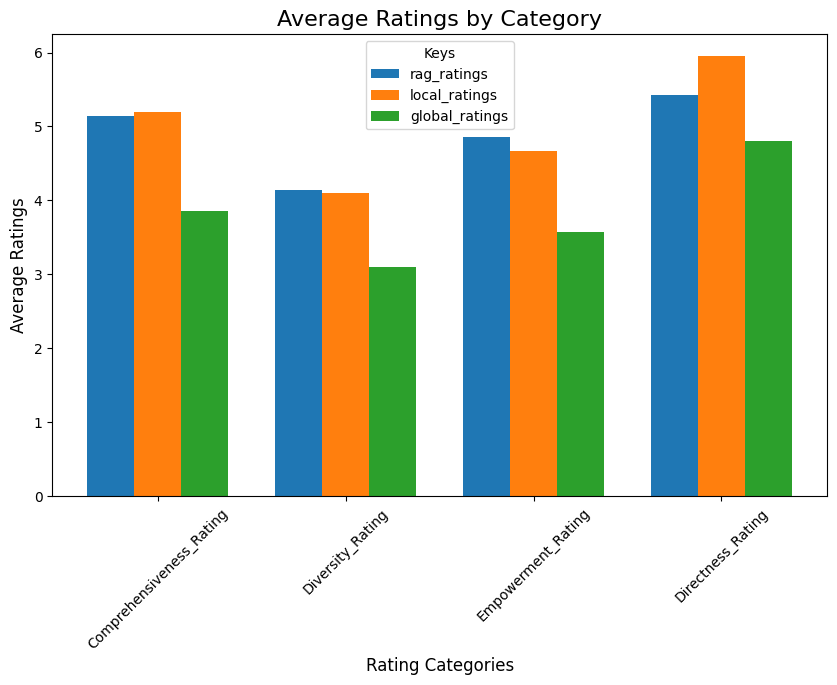

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example keys (replace with actual keys)
keys = ratings.keys()

# Ratings columns
ratings_columns = ['Comprehensiveness_Rating', 'Diversity_Rating', 'Empowerment_Rating', 'Directness_Rating']

# Bar width
bar_width = 0.25

# Number of categories (ratings_columns)
n_categories = len(ratings_columns)

# X-axis positions for the categories
x = np.arange(n_categories)

# Create the plot
plt.figure(figsize=(10, 6))

# Iterate through keys and plot the bars side by side
for i, k in enumerate(keys):
    # Load the data
    rag_ratings = pd.read_parquet(eval_path + k + '.parquet')
    data = rag_ratings[ratings_columns].astype(int)
    
    # Compute the mean ratings
    bars = data.sum() / data.count()
    
    # Shift the x positions for each key
    plt.bar(x + i * bar_width, bars.values, width=bar_width, label=k)

# Set x-tick positions and labels
plt.xticks(x + bar_width * (len(keys) - 1) / 2, ratings_columns, rotation=45)

# Add a horizontal dashed line at y=10
#plt.axhline(y=10, color='r', linestyle='--')

# Add labels and title
plt.xlabel('Rating Categories', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)
plt.title('Average Ratings by Category', fontsize=16)

# Add legend
plt.legend(title='Keys')

# Show the plot
plt.show()


In [19]:
result['local_search'] 

SearchResult(response='While the provided data focuses on the technical aspects of soldering,  it offers one suggestive point about its potential contribution to peaceful pursuits. The data mentions how soldering originally helped forge weapons but now could assist in developing intelligent machines that help mankind in peaceful endeavors [Data: Sources (25)]. \n\nThis statement implies that advancements in soldering technology and its application in electronics assembly could contribute to the development of machines and technologies that promote peace and human well-being. However, the data does not offer specific examples or elaborate on how these peaceful applications might emerge. \n', context_data={'reports':    id                               title occurrence weight  \
0  58  Soldering and Electronics Assembly               1.0   

                                             content  
0  # Soldering and Electronics Assembly\n\nThis c...  , 'relationships':      id             

In [93]:
from utils import answer_to_quesion,electronic_collection

print(question)

output = answer_to_quesion(electronic_collection,question)
print(output)

What are some industries where soldering is essential?
Soldering is a critical process in many industries, particularly those that involve the assembly of electronic devices. 

### Electronics Assembly 

Soldering is essential in the electronics assembly industry [Data: Source unit_text soldering.pdf_8]. It provides both mechanical and electrical support, allowing components to be joined together to form electrical connections. The widespread use of soldering in electronics assembly is due to its cost-effectiveness, ease of operation, and overall high performance compared to other methods [Data: Source unit_text soldering.pdf_8].

### Plumbing

The word "plumbing" itself originates from the Latin "plumbum," meaning lead, highlighting the historical use of soldering in plumbing systems [Data: Source unit_text soldering.pdf_9].  While lead plumbing is no longer common due to health concerns, soldering is still essential in modern plumbing, often using alloys of tin and lead [Data: Source

In [14]:
result.context_data["entities"].head()

,id,entity,description,number of relationships,in_context
0,191,SOLDERING TECHNOLOGY,Soldering technology refers to the techniques ...,3,True
1,13,SOLDERING,Soldering is a process that joins metal parts ...,120,True
2,486,SOLDERING ASSEMBLY,Soldering assembly is a key process in the ele...,3,True
3,46,HAND SOLDERING,Hand soldering is a manual process of joining ...,2,True
4,426,MACHINE SOLDERING,Machine soldering is a method of soldering tha...,3,True


In [15]:
result.context_data["relationships"].head()

,id,source,target,description,weight,rank,links,in_context
0,129,SOLDERING,SOLDERING TECHNOLOGY,Soldering is a process that is part of solderi...,8.0,123,1,True
1,176,SOLDERING,ELECTRICAL CONNECTION,Soldering is used to create electrical connect...,9.0,123,1,True
2,76,SOLDERING,HAND SOLDERING,Hand soldering is a type of soldering,5.0,122,1,True
3,175,SOLDERING,COMPONENT,Soldering is used to bond components together ...,9.0,137,2,True
4,62,SOLDERING,QUALITY,Soldering quality is a crucial aspect of elect...,21.0,129,2,True


In [16]:
result.context_data["reports"].head()

,id,title,content
0,58,Soldering and Electronics Assembly,# Soldering and Electronics Assembly\n\nThis c...
1,15,Electronics Assemblies and Soldering Processes,# Electronics Assemblies and Soldering Process...


In [17]:
result.context_data["sources"].head()

KeyError: 'sources'

In [18]:
print(result.context_text)

-----Reports-----
id|title|content
58|Soldering and Electronics Assembly|"# Soldering and Electronics Assembly

This community revolves around the process of soldering, which is used to join metal parts together, particularly in the context of electronics assembly. The community includes various entities related to soldering, such as solder, flux, solder pots and pumps, and solder pot heaters. It also encompasses broader concepts like safety, cleanliness, and assembly variations. The community's focus on electronics assembly highlights its importance in the manufacturing of electronic devices.

## Soldering as a core process

Soldering is the central entity in this community, serving as the primary process for joining metal parts together, particularly in electronics assembly. This process involves melting and flowing solder into the joint between two metal parts, creating a strong and reliable bond. [Data: Entities (13); Relationships (58, 71, 175, 74, 86, +more)]

## Importance of so

In [88]:
print(result.context_data['sources'])

KeyError: 'sources'

In [20]:
from graphrag.query.question_gen.local_gen import LocalQuestionGen

question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [21]:
question_history = [
    "Tell me about soldering process",
    "What happens in cleaning soldering?",
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

[{'role': 'system', 'content': '\n---Role---\n\nYou are a helpful assistant generating a bulleted list of 5 questions about data in the tables provided.\n\n\n---Data tables---\n\n-----Conversation History-----\nturn|content\nuser|Tell me about soldering process\n\n\n-----Reports-----\nid|title|content\n15|Electronics Assemblies and Soldering Processes|"# Electronics Assemblies and Soldering Processes\n\nThis community revolves around the creation of electronics assemblies, which are finished products made by soldering electronic components to a printed circuit board. The community includes various soldering processes, such as component/solder (CS) processes, solder/component (SC) processes, and inert atmosphere soldering, all of which are used to create different types of joints. The community also includes surface mounted components, which are used in electronics assemblies and are often soldered to the board using surface mount soldering processes.\n\n## Electronics Assemblies as the